In [1]:
'''
This script takes in data, calculates each persons reaction time, movement time, and timing mean and sd.
Then it plugs that in to the numerical simulations and runs it 

Then I graph the actual data with the optimal simulated data together to compare
'''

'\nThis script takes in data, calculates each persons reaction time, movement time, and timing mean and sd.\nThen it plugs that in to the numerical simulations and runs it \n\nThen I graph the actual data with the optimal simulated data together to compare\n'

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random
import numba as nb
from numba import njit
from operator import itemgetter

In [3]:
# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Pilot_v3')
PATH = os.getcwd()
save_path = '\\Figures\\'
if not os.path.exists(PATH+save_path):
        os.makedirs(PATH+save_path)

with open(PATH+"\\Analysis_Pull_List.txt","r") as pull_file:
    analysis_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt","r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()  
# SPECIFIC TO EXPERIMENT   
reaction_trials = 50    
timing_trials = 50
num_trials = 100 #number of trials in each block 
num_blocks = 6
tot_trials = num_trials*num_blocks
data_columns = len(fields_pull)
trial_time = 1500
NUM_SUBJECTS = len(analysis_pull_list)
wheel = dv.ColorWheel()

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

In [4]:
#%% Plot properties
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 

tp3_title = "1000,50"
tp4_title = "1000,150"
tp5_title = '1100,50'
tp6_title = "1100,150"
tp7_title = "1200,50"
tp8_title = '1200,150'
tp9_title = '1300,100'
tp10_title = '1300,200'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]

box_color1 = wheel.dark_blue
box_color2 = wheel.dark_red
box_color3 = '0.4'
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'
dot_color = 'black'   

### Functions

In [5]:
def update_params(label_color):
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              'figure.facecolor': 'black',
              'axes.facecolor' : 'black'
              }
    plt.rcParams.update(params)

In [6]:
def jitter(arr, data):
    if data.ndim >1:
        arr = np.tile(arr,(np.shape(data)[0],1))
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    else:
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    return arr

In [7]:
#%% Double Box plot with dots Function
def double_boxplot(X_locations, Y_locations, data1,data2, xlab, ylab, title, savename, save = False):
    if save:
        label_color = 'w'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    else:
        label_color = 'black'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    plt.figure(dpi = 125, figsize = (8,4))
    box_widths = 0.3
    X_locations = X_locations
    Y_locations = Y_locations
    ax = plt.subplot()
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    total = np.concatenate((data1, data2))
    ax.plot(jitter(X_locations+box_widths/2,np.shape(data1)).T, data1.T,color = '0.3', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    ax.plot(jitter(X_locations-box_widths/2, np.shape(data2)).T, data2.T,color = '0.3', marker= 'o', markerfacecolor = 'black', linewidth =1.5,alpha=0.5 )
    #bplot two  #block number, dyad, right/left
    ax.boxplot(data1, positions=X_locations+box_widths/2, patch_artist=True, boxprops = two_props, whiskerprops = two_whisk, 
                capprops = two_cap, medianprops = two_median, showfliers=False, widths = box_widths)
    #bplot three
    ax.boxplot(data2, positions = X_locations-box_widths/2, patch_artist=True, boxprops = three_props, whiskerprops = three_whisk,
                capprops = three_cap, medianprops=three_median, showfliers = False, widths = box_widths)
    ax.set_xticks(X_locations)
    ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(Y_locations)
    ax.set_yticklabels(Y_locations) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    
    labels = ["Indecisions", "Incorrect Decisions"]
    colors = [wheel.dark_blue, wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors, fontsize = 10)
    if save:
        plt.savefig(PATH+save_path+savename, dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

In [8]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None):
    og_xlocs = xlocs
    box_xlocs = xlocs
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*4
        xlocs = xlocs + shift_direction*box_widths*4
        if shift_direction == 1:
            props = [three_props,three_whisk,three_cap,three_median]
        else:
            props = [two_props,two_whisk,two_cap,two_median]

    filtered_data = data
    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    #ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.dark_blue,wheel.dark_red]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 10)


In [9]:
def combine_sd(n1,n2,avg1,avg2,sd1,sd2):
    ans = np.sqrt((((n1-1)*sd1**2 + (n2-1)*sd2**2)/(n1+n2-1)) + ((n1*n2*(avg1-avg2)**2)/((n1+n2)*(n1+n2-1))))
    return ans

In [10]:
def combined_sd(n1,n2,avg1,avg2,sd1,sd2):
    avg = (n1*avg1 + n2*avg2)/(n1+n2)
    ans = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2 + n1(avg1-avg)**2 + n2*(avg2-avg)**2))

In [11]:
def combine_sd1(n1,n2,sd1,sd2):
    ans = np.sqrt(sd1**2/n1 + sd2**2/n2)
    return ans

### Pickle

In [12]:
player_wins = np.zeros((NUM_SUBJECTS, num_blocks))
player_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_wins_first_half = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_wins_second_half = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_wins_cut_off = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_indecisions = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_indecisions_first_half = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_indecisions_second_half = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_indecisions_cut_off = np.zeros((NUM_SUBJECTS, num_blocks))
trial_table = np.empty((NUM_SUBJECTS, tot_trials, 4), int)
player_reach_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
player_decision_array = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
reaction_time = np.zeros([NUM_SUBJECTS,reaction_trials])*np.nan 
reaction_movement_time = np.zeros([NUM_SUBJECTS,reaction_trials])*np.nan 
rt_trial_start = np.zeros((NUM_SUBJECTS,reaction_trials))*np.nan 
timing_reach_time = np.zeros([NUM_SUBJECTS,reaction_trials])*np.nan 
hand_pos_data = np.zeros((NUM_SUBJECTS, num_blocks, num_trials, trial_time+500, 4))*np.nan
agent_decision_time = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))
agent_target_selection = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))
player_incorrect_decisions = np.zeros((NUM_SUBJECTS,num_blocks))
perc_player_incorrect_decisions = np.zeros((NUM_SUBJECTS,num_blocks))
perc_player_incorrect_decisions_first_half = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_incorrect_decisions_second_half = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_incorrect_decisions_cut_off = np.zeros((NUM_SUBJECTS, num_blocks))
player_decision_time = np.zeros([NUM_SUBJECTS,num_blocks,num_trials])*np.nan 
for i in range(NUM_SUBJECTS):
    subname = analysis_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_player_indecisions.pkl', 'rb'))
    player_wins[i,:] = pickle.load(open(data_path + f'{subname}_player_wins.pkl', 'rb'))
    perc_player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions.pkl', 'rb'))
    perc_player_indecisions_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_first_half.pkl', 'rb'))
    perc_player_indecisions_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_second_half.pkl', 'rb'))
    perc_player_indecisions_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_cut_off.pkl', 'rb'))
    
    perc_player_wins[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins.pkl', 'rb'))
    perc_player_wins_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_first_half.pkl', 'rb'))
    perc_player_wins_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_second_half.pkl', 'rb'))
    perc_player_wins_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_cut_off.pkl', 'rb'))
    
    perc_player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions.pkl', 'rb'))
    perc_player_incorrect_decisions_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_first_half.pkl', 'rb'))
    perc_player_incorrect_decisions_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_second_half.pkl', 'rb'))
    perc_player_incorrect_decisions_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_cut_off.pkl', 'rb'))
    #trial_table[i,:,:] = pickle.load(open(data_path + f'{subname}_trial_table.pkl', 'rb'))
    player_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_reach_time.pkl', 'rb'))
    hand_pos_data[i,:,:,:,:] = pickle.load(open(data_path+f'{subname}_hand_pos_data.pkl', 'rb'))
    reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_time.pkl', 'rb'))
    reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_movement_time.pkl', 'rb'))
    rt_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_rt_trial_start.pkl', 'rb'))
    agent_decision_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_decision_time.pkl', 'rb'))
    agent_target_selection[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_target_selection.pkl', 'rb'))
    player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_player_incorrect_decisions.pkl', 'rb'))
    player_decision_time[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_time.pkl', 'rb'))
    player_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_array.pkl', 'rb'))
    timing_reach_time[i,:] = pickle.load(open(data_path + f'{subname}_timing_reach_time.pkl', 'rb'))
agent_reach_time = agent_decision_time+150

### Calculations

Reaction and Reaction Movement Time

In [13]:
#%% Calculate RT means and sds
reaction_time_mean = np.zeros(NUM_SUBJECTS)
reaction_time_sd = np.zeros(NUM_SUBJECTS)
reaction_movement_time_mean = np.zeros(NUM_SUBJECTS)
reaction_movement_time_sd = np.zeros(NUM_SUBJECTS)
movement_time_mean = np.zeros(NUM_SUBJECTS)
movement_time_sd = np.zeros(NUM_SUBJECTS)
movement_time = reaction_movement_time - reaction_time
timing_reach_time_mean = np.nanmean(timing_reach_time, axis=1)
timing_reach_time_sd = np.nanstd(timing_reach_time, axis =1)

# Reaction time
for i in range(NUM_SUBJECTS):
    reaction_time_mean[i] = np.nanmean(reaction_time[i,10:])
    reaction_time_sd[i] = np.nanstd(reaction_time[i,10:])
    reaction_movement_time_mean[i] = np.nanmean(reaction_movement_time[i,10:])
    reaction_movement_time_sd[i] = np.nanstd(reaction_movement_time[i,10:])
    movement_time_mean[i] = np.nanmean(movement_time[i,10:])
    movement_time_sd[i] = np.nanstd(movement_time[i,10:])


Experiment reach and decision times

In [14]:
# Actual trials
agent_mean_reach_time = np.nanmean(agent_reach_time,axis = 2)
agent_sd_reach_time = np.nanstd(agent_reach_time,axis = 2)
agent_mean_decision_time = np.nanmean(agent_decision_time, axis =2)
agent_sd_decision_time = np.nanstd(agent_decision_time, axis =2)
player_mean_reach_time = np.nanmean(player_reach_time,axis=2)
player_sd_reach_time = np.nanstd(player_reach_time,axis=2)
player_mean_decision_time = np.nanmean(player_decision_time,axis=2)
player_sd_decision_time = np.nanstd(agent_reach_time,axis = 2)

Reach Times on Indecisions

In [15]:
#%% Find agent reach times for player indecisions
agent_decision_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
player_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
player_left_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))*np.nan
agent_mean_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
player_mean_reach_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
player_mean_left_time_on_indecisions = np.zeros((NUM_SUBJECTS,num_blocks))*np.nan
indecision_index = np.argwhere(player_reach_time>1500)

c=0
for i,j,k in indecision_index:
    agent_decision_time_on_indecisions[i,j,k] = agent_decision_time[i,j,k]
    player_reach_time_on_indecisions[i,j,k] = player_reach_time[i,j,k]
    player_left_time_on_indecisions[i,j,k] = player_decision_time[i,j,k]
    c+=1
for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        agent_mean_reach_time_on_indecisions[i,j] = np.nanmean(agent_decision_time_on_indecisions[i,j,:])
        player_mean_reach_time_on_indecisions[i,j] = np.nanmean(player_reach_time_on_indecisions[i,j,:])
        player_mean_left_time_on_indecisions[i,j] = np.nanmean(player_left_time_on_indecisions[i,j,:])



Wins when both decide

In [16]:
# Get agent decision array
agent_decision_array = np.zeros((NUM_SUBJECTS,num_blocks,num_trials))
player_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
perc_player_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
agent_both_reached_wins = np.zeros((NUM_SUBJECTS, num_blocks))
for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_reach_time[i,j,k]>1500:
                agent_decision_array[i,j,k] = 0
            else:
                agent_decision_array[i,j,k] = agent_target_selection[i,j,k]
# Get wins when both decide
both_decide_index = np.argwhere(np.logical_and(player_decision_array!=0,agent_decision_array!=0))

for i in range(NUM_SUBJECTS):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_decision_array[i,j,k]*player_decision_array[i,j,k] == 1:
                player_both_reached_wins[i,j]+=1
            if agent_decision_array[i,j,k]*player_decision_array[i,j,k] == -1:
                agent_both_reached_wins[i,j]+=1
        x = np.count_nonzero(player_decision_array[i,j,:]!=0)
        y = np.count_nonzero(agent_decision_array[i,j,:]!=0)
        if x!= 0 and y!= 0:
            total = np.count_nonzero(np.logical_and(player_decision_array[i,j,:]!=0,agent_decision_array[i,j,:]!=0))
            perc_player_both_reached_wins[i,j] = (player_both_reached_wins[i,j]/total)*100



### Simulation Functions

In [17]:
#%% Simulation Function Only P1 Sensory Feedback
@njit 
def Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME,NUM_TRIALS,REACTION_TIME,MOVEMENT_TIME, target_reach_means_p1, target_reach_means_agent,
                  p1_reach_time, agent_reach_time, p1_decision_time, agent_decision_time):
    # Initialize what I want to return
    p1_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_indecision = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_indecision = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    neither_decision = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_decision_array = np.empty((len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_decision_array = np.empty((len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS))
    p1_both_decided_array = np.empty((len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_both_decided_array = np.empty((len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS))
    
    p1_reaction_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_gamble_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_gamble_losses = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    c = -1 #decision time iterator
    
        # Simulation -------------------------------------------------------------
    for dt_p1 in (target_reach_means_p1):
        c=c+1
        z=-1
        for dt_agent in target_reach_means_agent:
            z=z+1
            for i in range(NUM_TRIALS): # can probably speed this up by doing the norm.rvs for the number of trials instead of running through a for loop, but not sure how to do the if statements then 
                
                #print(p1_reach_time[c,z,i],agent_reach_time[c,z,i])
                
                # Using sensory evidence ------------------------------------------
                # if player 1 is deciding after player 2 and player 2 has decided 
                # at least 200ms before 1500, then 1 can immediately win 
                
                if ((p1_decision_time[c,z,i] - agent_decision_time[c,z,i] >= REACTION_TIME) and (agent_decision_time[c,z,i] + REACTION_TIME + MOVEMENT_TIME < TRIAL_TIME)): # EVEN if p1 is over the trial time, if they can react in time to agent then this gets triggered
                    p1_wins[c,z] += 1
                    p1_reaction_wins[c,z] +=1
                    p1_decision_time[c,z,i] = agent_decision_time[c,z,i] + REACTION_TIME # change decision time to reaction time after opponent
                    p1_reach_time[c,z,i] = p1_decision_time[c,z,i] + MOVEMENT_TIME 
                    p1_decision_array[c,z,i] = 1
                    agent_decision_array[c,z,i] = -1
                    p1_both_decided_array[c,z,i] = 1
                    agent_both_decided_array[c,z,i] = -1
                    if p1_reach_time[c,z,i]>TRIAL_TIME:
                        print('ERROR')
                    # Know that agent didn't make an indecision because 1500-agent_dt >= 200 
                
                # if (agent_reach_time[c,z,i] >= p1_reach_time[c,z,i] +REACTION_TIME and 
                #       TRIAL_TIME - p1_reach_time[c,z,i] >=REACTION_TIME):
                #     agent_wins[c,z] += 1
                #     agent_reach_time[c,z,i] = p1_reach_time[c,z,i] +REACTION_TIME # change decision time to 200ms after opponent
                #     p1_decision_array[c,z,i] = -1
                #     agent_decision_array[c,z,i] = 1
                #     p1_both_decided_array[c,z,i] = -1
                #     agent_both_decided_array[c,z,i] = 1
                #-----------------------------------------------------------------
                # ------ No sensory evidence could be used------------------------
                
                # Both made it, random winner
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and
                      agent_reach_time[c,z,i]<TRIAL_TIME): 
                    rand = random.random()
                    if rand>=0.5:
                        p1_wins[c,z] += 1
                        p1_gamble_wins[c,z]+=1
                        p1_decision_array[c,z,i] = 1
                        agent_decision_array[c,z,i] = -1
                        p1_both_decided_array[c,z,i] = 1
                        agent_both_decided_array[c,z,i] = -1
                    else:
                        agent_wins[c,z] += 1    
                        p1_gamble_losses[c,z] += 1
                        p1_decision_array[c,z,i] = -1
                        agent_decision_array[c,z,i] = 1     
                        p1_both_decided_array[c,z,i] = -1
                        agent_both_decided_array[c,z,i] = 1                                                                                      
                # P1 didn't make it
                elif (p1_reach_time[c,z,i]>= TRIAL_TIME and
                      agent_reach_time[c,z,i]<TRIAL_TIME):
                    agent_wins[c,z] += 1
                    p1_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    agent_decision_array[c,z,i] = 1
                    p1_both_decided_array[c,z,i] = 0
                    agent_both_decided_array[c,z,i] = 1
                # agent didn't make it
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and 
                      agent_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_wins[c,z] += 1
                    p1_gamble_wins[c,z] += 1
                    agent_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 1
                    agent_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 1
                    agent_both_decided_array[c,z,i] = 0
                # Both didn't make it 
                elif (p1_reach_time[c,z,i]>=TRIAL_TIME and 
                      agent_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_indecision[c,z] += 1
                    agent_indecision[c,z] += 1
                    neither_decision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    agent_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 0
                    agent_both_decided_array[c,z,i] = 0
                else:
                    print("ERROR NO IF STATEMENT TRIGGERED")     
    return p1_wins, agent_wins, p1_indecision, agent_indecision, p1_reach_time, agent_reach_time, p1_decision_time,agent_decision_time, \
        p1_decision_array, agent_decision_array, p1_both_decided_array, agent_both_decided_array         

In [18]:
#%% Simulation Function Only P1 Sensory Feedback create mock data with bootstrapped reaciotn time, movement time, timing uncertainty, 
@njit 
def Simulate_Wins_Only_P1_Sensory_Feedback_Bootstrapped_Data(TRIAL_TIME,NUM_TRIALS,REACTION_TIME,MOVEMENT_TIME, 
                                                             NUM_SUBJECTS, agent_std, target_reach_means_p1, target_reach_means_agent,
                                                             p1_reach_time, agent_reach_time, p1_decision_time, agent_decision_time,
                                                             std_number):
    b = std_number
    # Initialize what I want to return
    p1_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_indecision = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_indecision = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    neither_decision = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_decision_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_decision_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS))
    p1_both_decided_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    agent_both_decided_array = np.empty((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent), NUM_TRIALS))
    
    p1_reaction_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_gamble_wins = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_gamble_losses = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
    c = -1 #decision time iterator
    print(np.shape(target_reach_means_p1))
        # Simulation -------------------------------------------------------------
    for dt_p1 in (target_reach_means_p1):
        c=c+1
        z=-1
        for dt_agent in target_reach_means_agent:
            z=z+1
            for i in range(NUM_TRIALS): # can probably speed this up by doing the norm.rvs for the number of trials instead of running through a for loop, but not sure how to do the if statements then 
                
                #print(p1_reach_time[b,c,z,i],agent_reach_time[b,c,z,i])
                
                # Using sensory evidence ------------------------------------------
                # if player 1 is deciding after player 2 and player 2 has decided 
                # at least 200ms before 1500, then 1 can immediately win 
                
                if ((p1_decision_time[b,c,z,i] - agent_decision_time[b,c,z,i] >= REACTION_TIME) and (agent_decision_time[b,c,z,i] + REACTION_TIME + MOVEMENT_TIME < TRIAL_TIME)): # EVEN if p1 is over the trial time, if they can react in time to agent then this gets triggered
                    p1_wins[c,z] += 1
                    p1_reaction_wins[c,z] +=1
                    p1_decision_time[b,c,z,i] = agent_decision_time[b,c,z,i] + REACTION_TIME # change decision time to reaction time after opponent
                    p1_reach_time[b,c,z,i] = p1_decision_time[b,c,z,i] + MOVEMENT_TIME 
                    p1_decision_array[b,c,z,i] = 1
                    agent_decision_array[b,c,z,i] = -1
                    p1_both_decided_array[b,c,z,i] = 1
                    agent_both_decided_array[b,c,z,i] = -1
                    if p1_reach_time[b,c,z,i]>TRIAL_TIME:
                        print('ERROR')
                    # Know that agent didn't make an indecision because 1500-agent_dt >= 200 
                
                # if (agent_reach_time[b,c,z,i] >= p1_reach_time[b,c,z,i] +REACTION_TIME and 
                #       TRIAL_TIME - p1_reach_time[b,c,z,i] >=REACTION_TIME):
                #     agent_wins[c,z] += 1
                #     agent_reach_time[b,c,z,i] = p1_reach_time[b,c,z,i] +REACTION_TIME # change decision time to 200ms after opponent
                #     p1_decision_array[b,c,z,i] = -1
                #     agent_decision_array[b,c,z,i] = 1
                #     p1_both_decided_array[b,c,z,i] = -1
                #     agent_both_decided_array[b,c,z,i] = 1
                #-----------------------------------------------------------------
                # ------ No sensory evidence could be used------------------------
                
                # Both made it, random winner
                elif (p1_reach_time[b,c,z,i]<TRIAL_TIME and
                      agent_reach_time[b,c,z,i]<TRIAL_TIME): 
                    rand = random.random()
                    if rand>=0.5:
                        p1_wins[c,z] += 1
                        p1_gamble_wins[c,z]+=1
                        p1_decision_array[b,c,z,i] = 1
                        agent_decision_array[b,c,z,i] = -1
                        p1_both_decided_array[b,c,z,i] = 1
                        agent_both_decided_array[b,c,z,i] = -1
                    else:
                        agent_wins[c,z] += 1    
                        p1_gamble_losses[c,z] += 1
                        p1_decision_array[b,c,z,i] = -1
                        agent_decision_array[b,c,z,i] = 1     
                        p1_both_decided_array[b,c,z,i] = -1
                        agent_both_decided_array[b,c,z,i] = 1                                                                                      
                # P1 didn't make it
                elif (p1_reach_time[b,c,z,i]>= TRIAL_TIME and
                      agent_reach_time[b,c,z,i]<TRIAL_TIME):
                    agent_wins[c,z] += 1
                    p1_indecision[c,z] += 1
                    p1_decision_array[b,c,z,i] = 0
                    agent_decision_array[b,c,z,i] = 1
                    p1_both_decided_array[b,c,z,i] = 0
                    agent_both_decided_array[b,c,z,i] = 1
                # agent didn't make it
                elif (p1_reach_time[b,c,z,i]<TRIAL_TIME and 
                      agent_reach_time[b,c,z,i]>=TRIAL_TIME):
                    p1_wins[c,z] += 1
                    p1_gamble_wins[c,z] += 1
                    agent_indecision[c,z] += 1
                    p1_decision_array[b,c,z,i] = 1
                    agent_decision_array[b,c,z,i] = 0
                    p1_both_decided_array[b,c,z,i] = 1
                    agent_both_decided_array[b,c,z,i] = 0
                # Both didn't make it 
                elif (p1_reach_time[b,c,z,i]>=TRIAL_TIME and 
                      agent_reach_time[b,c,z,i]>=TRIAL_TIME):
                    p1_indecision[c,z] += 1
                    agent_indecision[c,z] += 1
                    neither_decision[c,z] += 1
                    p1_decision_array[b,c,z,i] = 0
                    agent_decision_array[b,c,z,i] = 0
                    p1_both_decided_array[b,c,z,i] = 0
                    agent_both_decided_array[b,c,z,i] = 0
                else:
                    print("ERROR NO IF STATEMENT TRIGGERED")     
    return p1_wins, agent_wins, p1_indecision, agent_indecision, p1_reach_time, agent_reach_time, p1_decision_time,agent_decision_time, \
        p1_decision_array, agent_decision_array, p1_both_decided_array, agent_both_decided_array         

In [19]:
#%% Calculate both decided wins
@njit
def calc_both_decide_wins(NUM_TRIALS, target_reach_means_p1,target_reach_means_agent,
                          p1_decision_array,
                          agent_decision_array, 
                          p1_both_decided_array, 
                          agent_both_decided_array):
    p1_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    p1_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
    agent_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
       
    # p1_both_decided_array = p1_decision_array #decision array
    # agent_both_decided_array = agent_decision_array     
    p1_indecision_index = np.argwhere(p1_decision_array == 0)
    agent_indecision_index = np.argwhere(agent_decision_array == 0)
      # Create arrays for when both decide 
      #Replace all 0's (indecisions) with nans
    for i,j,k in p1_indecision_index:
        p1_both_decided_array[i,j,k] = np.nan
        agent_both_decided_array[i,j,k] = np.nan
    for i,j,k in agent_indecision_index:
       p1_both_decided_array[i,j,k] = np.nan
       agent_both_decided_array[i,j,k] = np.nan
    
    # Count wins for each when both decide
    for i in range(len(target_reach_means_p1)):
        for j in range(len(target_reach_means_agent)):
            for k in range(NUM_TRIALS):
                if p1_both_decided_array[i,j,k]==1 and agent_both_decided_array[i,j,k] == -1:
                    p1_both_decided_wins[i,j] += 1
                    # if np.isnan(p1_both_decided_array[i]):
                    #     print('error')
                    #print(f"Right wins on correct choice: {decision_array_R[i,j,k]}, {decision_array_L[i,j,k]}")
                # Prey won for correct choice
                elif agent_both_decided_array[i,j,k]==1 and p1_both_decided_array[i,j,k] == -1:
                    agent_both_decided_wins[i,j] += 1
                    
            x = np.count_nonzero(~np.isnan(p1_both_decided_array[i,j,:]))
            y = np.count_nonzero(~np.isnan(agent_both_decided_array[i,j,:]))
            if x != 0 and y != 0:
                total = np.count_nonzero(np.logical_and(p1_decision_array[i,j,:]!=0,agent_decision_array[i,j,:]!=0))
                p1_perc_both_decided_wins[i,j] = (p1_both_decided_wins[i,j] / total)*100
                agent_perc_both_decided_wins[i,j] = (agent_both_decided_wins[i,j] / total)*100
            else:
                p1_perc_both_decided_wins[i,j] = np.nan
                agent_perc_both_decided_wins[i,j] = np.nan
        
    return p1_perc_both_decided_wins, agent_perc_both_decided_wins


### Run Simulation with subject data 


In [20]:
print(timing_reach_time_sd)
print(reaction_movement_time_sd)

[65.45952646 77.8018226  91.22691708 69.37429207 68.64093239]
[ 40.74002178  74.39959677  24.7074761   34.46403016 109.02068611]


Reaction Time Mean = 300.0
Timing_reach_time_mean = 1478.7755102040817
Overall Uncertainty = 106.19954824420685
(5.4399999999999995, 0.1, 0.08) [ 5.  8. 34.]


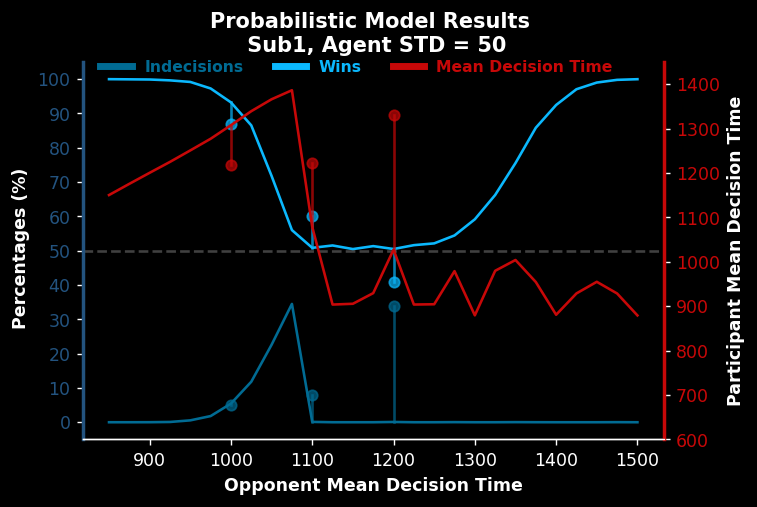

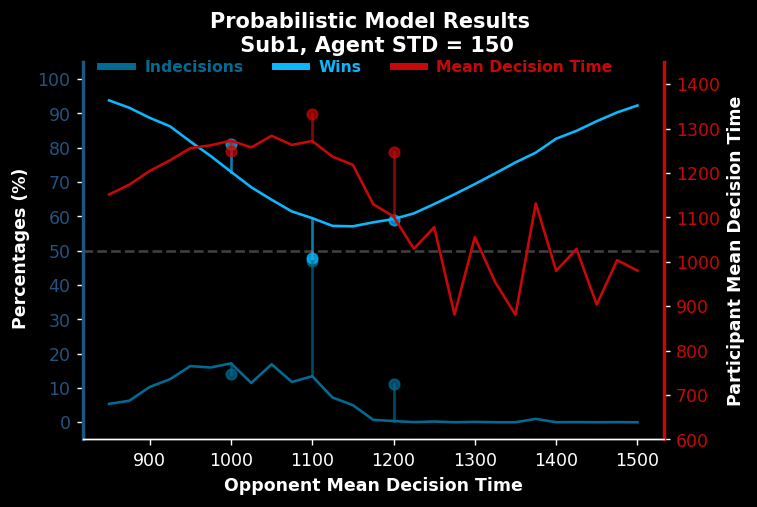

Reaction Time Mean = 306.125
Timing_reach_time_mean = 1436.42
Overall Uncertainty = 152.20141937386003
(21.990000000000002, 0.05, 0.12) [10. 11. 26.]


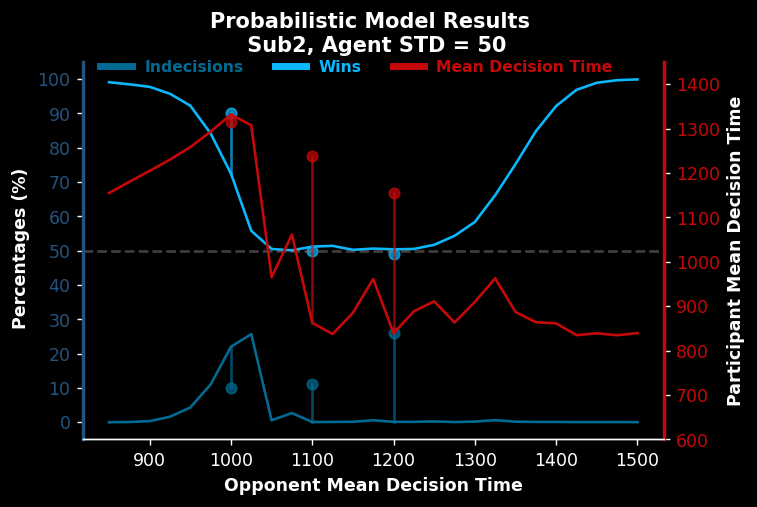

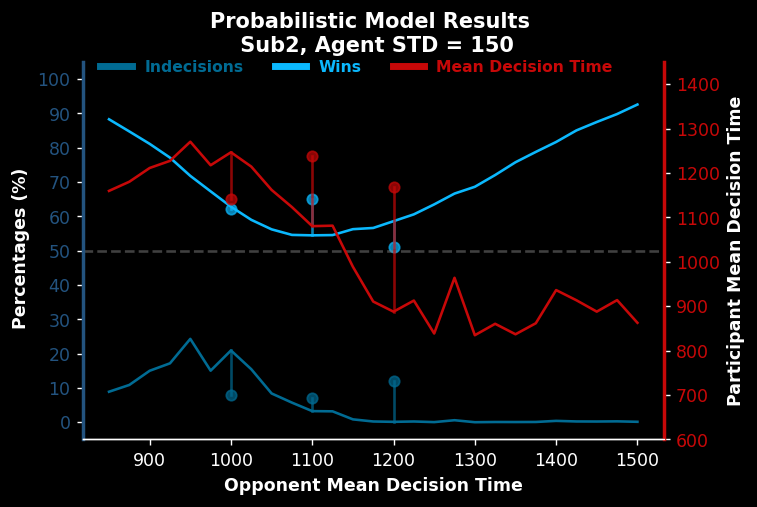

Reaction Time Mean = 282.675
Timing_reach_time_mean = 1487.36
Overall Uncertainty = 115.93439317573552
(21.95, 0.01, 0.05) [10. 18.  1.]


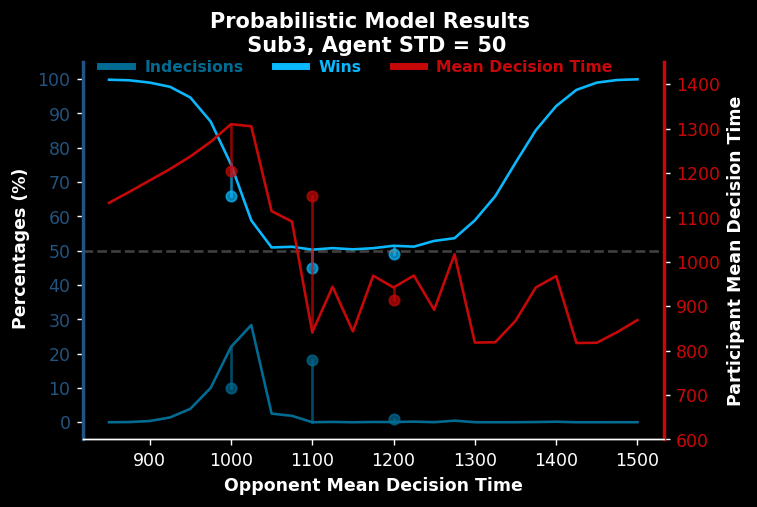

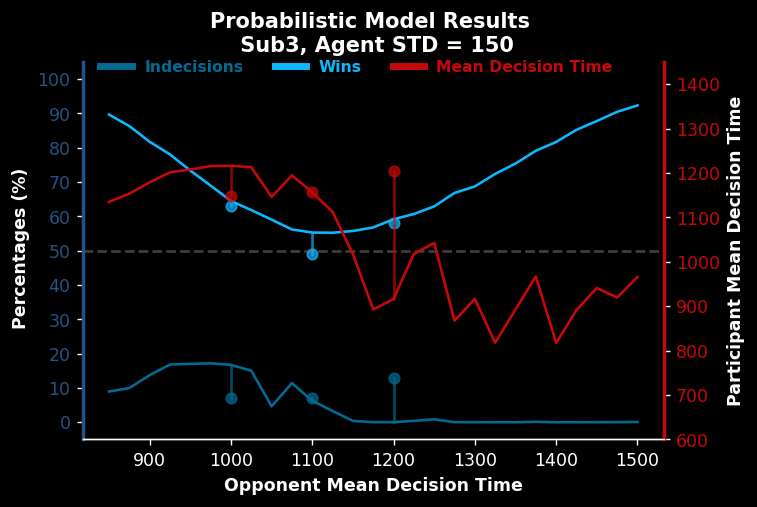

Reaction Time Mean = 300.15
Timing_reach_time_mean = 1457.74
Overall Uncertainty = 103.83832223035495
(23.23, 0.06, 0.05) [ 5.  9. 14.]


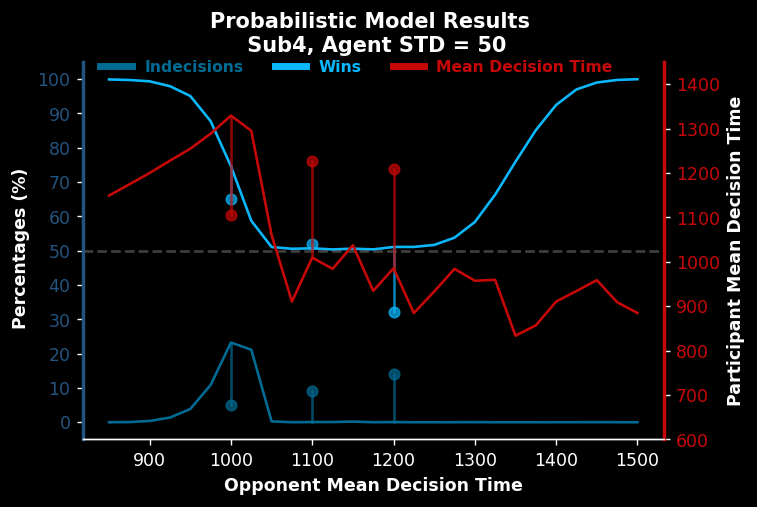

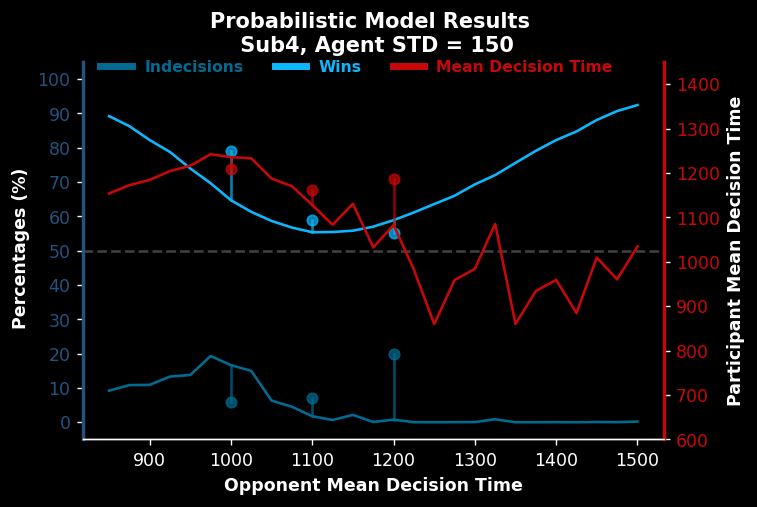

Reaction Time Mean = 270.575
Timing_reach_time_mean = 1468.32
Overall Uncertainty = 177.66161850508055
(0.8, 31.53, 0.22999999999999998) [ 1. 36. 64.]


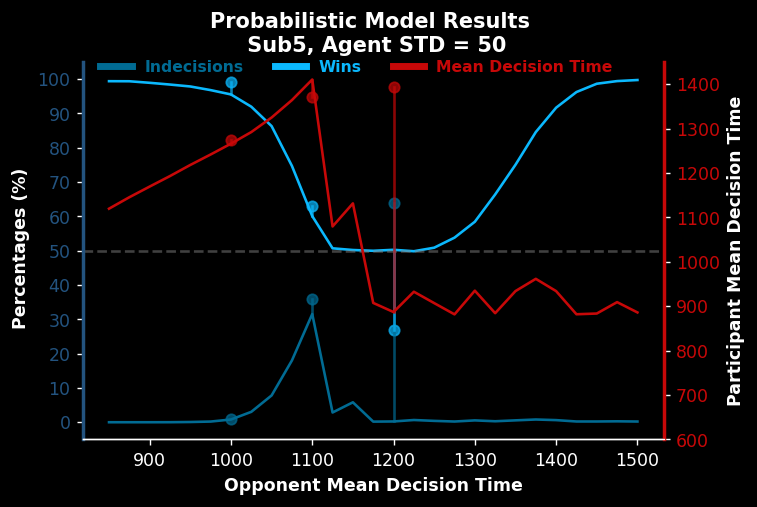

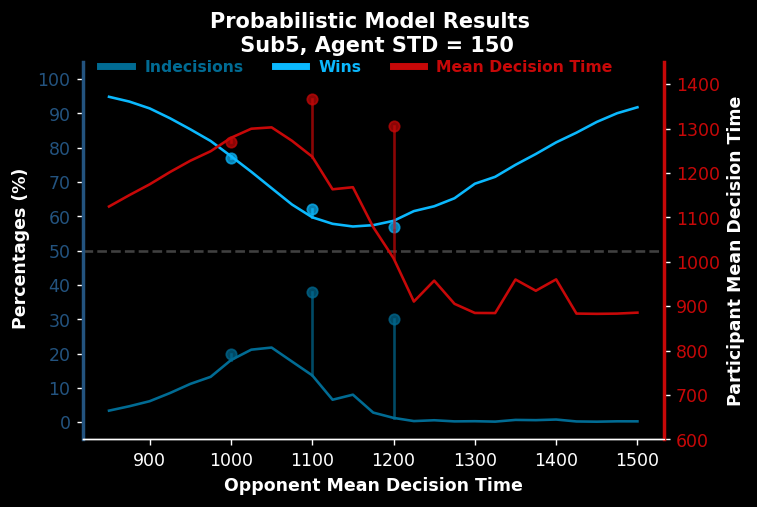

In [21]:
# Calculate std of player
subject_number = np.arange(0,NUM_SUBJECTS)
condition_times = np.array([1000,1100,1200])

for sub_num in subject_number:
    p1_std = reaction_movement_time_sd[sub_num]+timing_reach_time_sd[sub_num]
    print(f"Reaction Time Mean = {reaction_time_mean[sub_num]}")
    print(f'Timing_reach_time_mean = {timing_reach_time_mean[sub_num]}')
    print(f'Overall Uncertainty = {p1_std}')
    p1_std = [p1_std]
    agent_std = [50,150]
    update_params('w')
    figs = [] # Empty list to store figures so I can change them around on the next cell
    a,b = -1,-1
    for sig1 in (p1_std):
        a+=1
        for sig2 in agent_std:
            b+=1
            #%% Constant Variables
            TRIAL_TIME = 1500
            NUM_TRIALS = 10000
            REACTION_TIME = reaction_time_mean[sub_num]
            MOVEMENT_TIME = movement_time_mean[sub_num]
            AGENT_MOVEMENT_TIME = 150
            #Start and end decision time for player 1
            interval = 25
            start_time1 = 1000
            end_time1 = 1650
            total_times1 = int((end_time1 - start_time1) / interval)+1
            target_reach_means_p1 = np.zeros(total_times1)
            # Start and end decision time for player 2
            start_time = 1000
            end_time = 1650
            total_times2 = int((end_time - start_time) / interval)+1
            target_reach_means_agent = np.zeros(total_times2)
            # Creating AVERAGE decision time arrays
            # To be used in the norm.rvs
            for i in range(total_times1):
                target_reach_means_p1[i] = start_time1
                start_time1 = start_time1 + interval
            for i in range(total_times2):
                target_reach_means_agent[i] = start_time
                start_time = start_time + interval
            target_reach_means_p1 = target_reach_means_p1.astype(int)
            target_reach_means_agent = target_reach_means_agent.astype(int)
            agent_decision_means = target_reach_means_agent - AGENT_MOVEMENT_TIME
            #Decision time storage arrays
            p1_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
            agent_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
            p1_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
            agent_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
            p1_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
            agent_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
            
            #%% Run Simulation w/ SD = 100,100
            
            c=-1
            for dt_p1 in (target_reach_means_p1):
                c=c+1
                z=-1
                for dt_agent in target_reach_means_agent:
                    z=z+1
                    # p1_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                    # agent_reach_time[c,z,:] = skewnorm.rvs(-3, dt_agent, 100, size = NUM_TRIALS)
                    p1_reach_time[c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS)
                    agent_reach_time[c,z,:] = norm.rvs(dt_agent, sig2, size = NUM_TRIALS)
            p1_decision_time = p1_reach_time - MOVEMENT_TIME
            agent_decision_time = agent_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


            #make response time arrays
            # for dt_p1 in tqdm(target_reach_means_p1):
            #         c=c+1
            #         z=-1
            #         for dt_agent in target_reach_means_agent:
            #             z=z+1

            #-----------------------------------------------------------------------------
            p1_wins, agent_wins, p1_indecision, agent_indecision, \
                p1_reach_time, agent_reach_time, p1_decision_time, agent_decision_time, p1_decision_array, agent_decision_array, \
                    p1_both_decided_array, agent_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, REACTION_TIME,MOVEMENT_TIME,
                                                                                                        target_reach_means_p1, target_reach_means_agent, 
                                                                                                        p1_reach_time, agent_reach_time,
                                                                                                        p1_decision_time,agent_decision_time)
            # Calculate both decided wins
            p1_perc_both_decided_wins, agent_perc_both_decided_wins = \
                calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_agent, p1_decision_array, agent_decision_array,  p1_both_decided_array,agent_both_decided_array)
            # Caluclate mean decision times
            
            #%% Find optimal control policy 
            # Find average of actual decision times
            p1_avg_dt = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
            p1_avg_dt_final = np.zeros(len(target_reach_means_p1))
            for i in range(len(target_reach_means_p1)):
                for j in range(len(target_reach_means_agent)):
                    p1_avg_dt[i,j] = np.mean(p1_decision_time[i,j,:])
            for i in range(len(target_reach_means_p1)):
                p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])  
                
            optimal_mean_decision_time = np.zeros(len(target_reach_means_p1))
            optimal_indecisions = np.zeros(len(target_reach_means_p1))
            optimal_wins = np.zeros(len(target_reach_means_p1))
            perc_optimal_both_decided_wins = np.zeros(len(target_reach_means_p1))
            for j in range(len(target_reach_means_agent)):
                max_win_index = np.argmax(p1_wins[:,j])
                optimal_mean_decision_time[j] = p1_avg_dt[max_win_index,j]
                optimal_indecisions[j] = p1_indecision[max_win_index,j]
                optimal_wins[j] = p1_wins[max_win_index,j]
                perc_optimal_both_decided_wins[j] = p1_perc_both_decided_wins[max_win_index,j]
            perc_optimal_wins = optimal_wins/NUM_TRIALS*100
            perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

            # #%% All on one, with vertical lines on the selected mean decision time
            # plt.figure(dpi=125)
            # ax = plt.subplot()
            # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
            # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
            # #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
            # ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
            # # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
            # # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
            # ax.set_ylim(-5,105)
            # ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
            # ax.set_xlabel("Opponent Mean Decision Time")
            # ax.set_ylabel(' Percentages (%)')
            # ax.spines['left'].set_color(wheel.dark_blue)
            # ax.spines['left'].set_linewidth(2)
            # ax.spines['top'].set_visible(False)

            # ax2 = ax.twinx()
            # ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time,'-o', c=wheel.dark_red)
            # ax2.set_yticks(np.arange(400,1600,100))
            # ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
            # ax2.set_ylim(600,1400)
            # ax2.spines['right'].set_visible(True)
            # ax2.spines['right'].set_color(wheel.dark_red)
            # ax2.spines['right'].set_linewidth(2)
            # ax2.set_ylabel('Participant Mean Decision Time')
            # ax2.spines['left'].set_visible(False)
            # ax2.spines['top'].set_visible(False)
            # #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
            # ax.set_title('Probabilistic Model Results')
            # labels = ['Indecisions', 'Wins','Mean Decision Time']
            # colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
            # dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3)
            # #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{REACTION_TIME}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
            # plt.show()
            
            # Plot lines with the player means as points
            index = []
            for x in condition_times:
                index.append(np.argwhere(agent_decision_means==x))
            perc_optimal_indecisions1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_indecisions) # itemgetter gets 3 specific indecies from the thing in parentheses, in this case perc_optimal_indecisions
            perc_optimal_wins1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_wins)
            optimal_mean_decision_time1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(optimal_mean_decision_time)
            if sig2 == 50:
                player_mean_decision_time1 = player_mean_decision_time[sub_num,::2] # This takes every other index, so only the 50 std ones
                perc_player_indecisions1 = perc_player_indecisions[sub_num,::2]
                perc_player_wins1 = perc_player_wins[sub_num,::2]
                print(perc_optimal_indecisions1,perc_player_indecisions1)
            else:
                perc_player_indecisions1 = perc_player_indecisions[sub_num,1::2]
                perc_player_wins1 = perc_player_wins[sub_num,1::2]
                player_mean_decision_time1 = player_mean_decision_time[sub_num,1::2] # Same as above but starts at index of 1
                
            fig,ax = plt.subplots(dpi = 125)
            ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions, c = wheel.dark_blue2, label = 'Indecisions')
            ax.scatter(condition_times,perc_player_indecisions1, c = wheel.dark_blue2,alpha=0.7)    
            ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins, c = wheel.light_blue, label = 'Wins')
            ax.scatter(condition_times,perc_player_wins1, c = wheel.light_blue,alpha=0.7)
            ax.plot((condition_times,condition_times),(perc_optimal_indecisions1,perc_player_indecisions1), c= wheel.dark_blue2,alpha=0.7)
            ax.plot((condition_times,condition_times),(perc_optimal_wins1,perc_player_wins1), c= wheel.light_blue, alpha = 0.7)
            #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
            ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
            # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
            # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
            ax.set_ylim(-5,105)
            ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
            ax.set_xlabel("Opponent Mean Decision Time")
            ax.set_ylabel(' Percentages (%)')
            ax.spines['left'].set_color(wheel.dark_blue)
            ax.spines['left'].set_linewidth(2)
            ax.spines['top'].set_visible(False)

            ax2 = ax.twinx()
            ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time, c=wheel.dark_red)
            ax2.scatter(condition_times, player_mean_decision_time1, c= wheel.dark_red, alpha = 0.7)
            ax2.plot((condition_times,condition_times),(optimal_mean_decision_time1,player_mean_decision_time1), c= wheel.dark_red, alpha = 0.7)

            c=-1
            # for x in condition_times:
            #     c+=1
            #     index = np.argwhere(target_reach_means_agent == x)
            #     index = index[0][0]
            #     print(perc_optimal_indecisions[index],perc_optimal_wins[index],optimal_mean_decision_time[index])
            #     ax.axvline(x,perc_optimal_indecisions[index],perc_player_indecisions1[c])
            #     ax.axvline(x,perc_optimal_wins[index],perc_player_wins1[c])
            #     ax2.axvline(x,optimal_mean_decision_time[index],player_mean_decision_time1[c])
                
            ax2.set_yticks(np.arange(400,1600,100))
            ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
            ax2.set_ylim(600,1450)
            ax2.spines['right'].set_visible(True)
            ax2.spines['right'].set_color(wheel.dark_red)
            ax2.spines['right'].set_linewidth(2)
            ax2.set_ylabel('Participant Mean Decision Time')
            ax2.spines['left'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
            ax.set_title(f'Probabilistic Model Results \n Sub{sub_num+1}, Agent STD = {sig2}')
            labels = ['Indecisions', 'Wins','Mean Decision Time']
            colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
            dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3, columnspacing=2)
            #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{REACTION_TIME}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
            plt.show()
            figs.append(fig)
        
        
        #plot_list.append(ax)

### Average everything together and run again

Average data

In [22]:
mean_of_mean_reaction_time = np.mean(reaction_time_mean)
mean_of_mean_movement_time = np.mean(movement_time_mean)
mean_of_sd_reaction_time = np.mean(reaction_time_sd)
mean_of_sd_reaction_movement_time = np.mean(reaction_movement_time_sd)
mean_of_sd_timing_time = np.mean(timing_reach_time_sd)
mean_indecisions_across_participants = np.mean(perc_player_indecisions,axis=0)
mean_wins_across_participants = np.mean(perc_player_wins,axis=0)
mean_of_mean_decision_time = np.mean(player_mean_decision_time,axis=0)

In [23]:
np.mean(perc_player_wins,axis=0)

array([81.4, 72.4, 54. , 56.6, 39.6, 56. ])

Run sim with averaged data

Reaction Time Mean = 291.905
Overall Uncertainty = 151.1670603058476


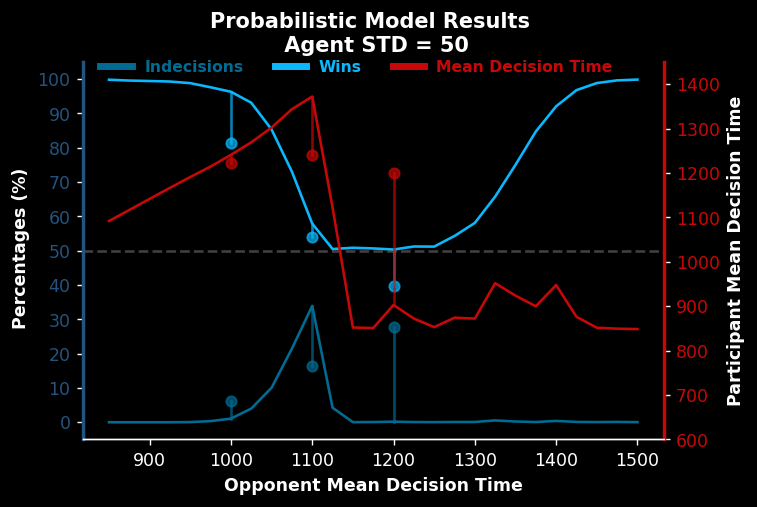

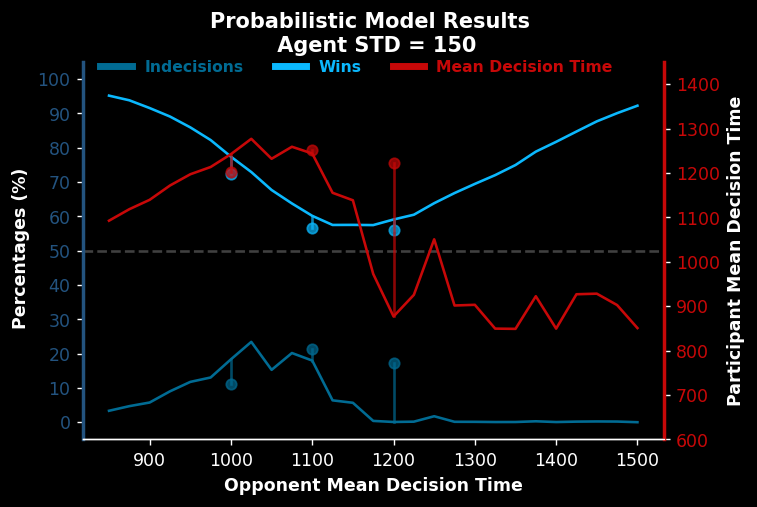

In [24]:

subject_number = np.arange(0,NUM_SUBJECTS)
condition_times = [1000,1100,1200]


p1_std = mean_of_sd_reaction_movement_time + mean_of_sd_timing_time + 20
print(f"Reaction Time Mean = {mean_of_mean_reaction_time}")
print(f'Overall Uncertainty = {p1_std}')
p1_std = [p1_std]
agent_std = [50,150]
update_params('w')
figs = [] # Empty list to store figures so I can change them around on the next cell
a,b = -1,-1
for sig1 in (p1_std):
    a+=1
    for sig2 in agent_std:
        b+=1
        #%% Constant Variables
        TRIAL_TIME = 1500
        NUM_TRIALS = 10000
        REACTION_TIME = mean_of_mean_reaction_time - 50
        MOVEMENT_TIME = mean_of_mean_movement_time
        AGENT_MOVEMENT_TIME = 150 
        #Start and end decision time for player 1
        interval = 25
        start_time1 = 1000
        end_time1 = 1650
        total_times1 = int((end_time1 - start_time1) / interval)+1
        target_reach_means_p1 = np.zeros(total_times1)
        # Start and end decision time for player 2
        start_time = 1000
        end_time = 1650
        total_times2 = int((end_time - start_time) / interval)+1
        target_reach_means_agent = np.zeros(total_times2)
        # Creating AVERAGE decision time arrays
        # To be used in the norm.rvs
        for i in range(total_times1):
            target_reach_means_p1[i] = start_time1
            start_time1 = start_time1 + interval
        for i in range(total_times2):
            target_reach_means_agent[i] = start_time
            start_time = start_time + interval
        target_reach_means_p1 = target_reach_means_p1.astype(int)
        target_reach_means_agent = target_reach_means_agent.astype(int)
        agent_decision_means = target_reach_means_agent - AGENT_MOVEMENT_TIME
        #Decision time storage arrays
        p1_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        agent_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        p1_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        agent_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        p1_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        agent_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
        
        #%% Run Simulation w/ SD = 100,100
        
        c=-1
        for dt_p1 in (target_reach_means_p1):
            c=c+1
            z=-1
            for dt_agent in target_reach_means_agent:
                z=z+1
                # p1_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                # agent_reach_time[c,z,:] = skewnorm.rvs(-3, dt_agent, 100, size = NUM_TRIALS)
                p1_reach_time[c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS)
                agent_reach_time[c,z,:] = norm.rvs(dt_agent, sig2, size = NUM_TRIALS)
        p1_decision_time = p1_reach_time - MOVEMENT_TIME
        agent_decision_time = agent_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


        #make response time arrays
        # for dt_p1 in tqdm(target_reach_means_p1):
        #         c=c+1
        #         z=-1
        #         for dt_agent in target_reach_means_agent:
        #             z=z+1

        #-----------------------------------------------------------------------------
        p1_wins, agent_wins, p1_indecision, agent_indecision, \
            p1_reach_time, agent_reach_time, p1_decision_time, agent_decision_time, p1_decision_array, agent_decision_array, \
                p1_both_decided_array, agent_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, REACTION_TIME,MOVEMENT_TIME,
                                                                                                    target_reach_means_p1, target_reach_means_agent, 
                                                                                                    p1_reach_time, agent_reach_time,
                                                                                                    p1_decision_time,agent_decision_time)
        # Calculate both decided wins
        p1_perc_both_decided_wins, agent_perc_both_decided_wins = \
            calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_agent, p1_decision_array, agent_decision_array,  p1_both_decided_array,agent_both_decided_array)
        # Caluclate mean decision times
        
        #%% Find optimal control policy 
        # Find average of actual decision times
        p1_avg_dt = np.zeros((len(target_reach_means_p1), len(target_reach_means_agent)))
        p1_avg_dt_final = np.zeros(len(target_reach_means_p1))
        for i in range(len(target_reach_means_p1)):
            for j in range(len(target_reach_means_agent)):
                p1_avg_dt[i,j] = np.mean(p1_decision_time[i,j,:])
        for i in range(len(target_reach_means_p1)):
            p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])  
            
        optimal_mean_decision_time = np.zeros(len(target_reach_means_p1))
        optimal_indecisions = np.zeros(len(target_reach_means_p1))
        optimal_wins = np.zeros(len(target_reach_means_p1))
        perc_optimal_both_decided_wins = np.zeros(len(target_reach_means_p1))
        for j in range(len(target_reach_means_agent)):
            max_win_index = np.argmax(p1_wins[:,j])
            optimal_mean_decision_time[j] = p1_avg_dt[max_win_index,j]
            optimal_indecisions[j] = p1_indecision[max_win_index,j]
            optimal_wins[j] = p1_wins[max_win_index,j]
            perc_optimal_both_decided_wins[j] = p1_perc_both_decided_wins[max_win_index,j]
        perc_optimal_wins = optimal_wins/NUM_TRIALS*100
        perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

        # #%% All on one, with vertical lines on the selected mean decision time
        # plt.figure(dpi=125)
        # ax = plt.subplot()
        # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
        # ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
        # #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
        # ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
        # # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
        # # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
        # ax.set_ylim(-5,105)
        # ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
        # ax.set_xlabel("Opponent Mean Decision Time")
        # ax.set_ylabel(' Percentages (%)')
        # ax.spines['left'].set_color(wheel.dark_blue)
        # ax.spines['left'].set_linewidth(2)
        # ax.spines['top'].set_visible(False)

        # ax2 = ax.twinx()
        # ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time,'-o', c=wheel.dark_red)
        # ax2.set_yticks(np.arange(400,1600,100))
        # ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
        # ax2.set_ylim(600,1400)
        # ax2.spines['right'].set_visible(True)
        # ax2.spines['right'].set_color(wheel.dark_red)
        # ax2.spines['right'].set_linewidth(2)
        # ax2.set_ylabel('Participant Mean Decision Time')
        # ax2.spines['left'].set_visible(False)
        # ax2.spines['top'].set_visible(False)
        # #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
        # ax.set_title('Probabilistic Model Results')
        # labels = ['Indecisions', 'Wins','Mean Decision Time']
        # colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
        # dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3)
        # #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{REACTION_TIME}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
        # plt.show()
        
        #%% Plot lines with the player means as points
        # First make an array with only the optimal decisions of that specific agent decision time
        index = []
        for x in condition_times:
            index.append(np.argwhere(agent_decision_means==x))
        perc_optimal_indecisions1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_indecisions) # itemgetter gets 3 specific indecies from the thing in parentheses, in this case perc_optimal_indecisions
        perc_optimal_wins1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(perc_optimal_wins)
        optimal_mean_decision_time1 = itemgetter(index[0][0][0],index[1][0][0],index[2][0][0])(optimal_mean_decision_time)
        # Split by agent std of 50 and 150
        if sig2 == agent_std[0]:
            mean_of_mean_decision_time1 = mean_of_mean_decision_time[::2] # This takes every other index, so only the 50 std ones
            mean_indecisions_across_participants1 = mean_indecisions_across_participants[::2]
            mean_wins_across_participants1 = mean_wins_across_participants[::2]    
        else:
            mean_of_mean_decision_time1 = mean_of_mean_decision_time[1::2] # This takes every other index, so only the 50 std ones
            mean_indecisions_across_participants1 = mean_indecisions_across_participants[1::2]
            mean_wins_across_participants1 = mean_wins_across_participants[1::2]    # Same as above but starts at index of 1
            
        fig,ax = plt.subplots(dpi = 125)
        ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_indecisions, c = wheel.dark_blue2, label = 'Indecisions')
        ax.scatter(condition_times,mean_indecisions_across_participants1, c = wheel.dark_blue2,alpha=0.7)    
        ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_wins, c = wheel.light_blue, label = 'Wins')
        ax.scatter(condition_times,mean_wins_across_participants1, c = wheel.light_blue,alpha=0.7)
        ax.plot((condition_times,condition_times),(perc_optimal_indecisions1,mean_indecisions_across_participants1), c= wheel.dark_blue2,alpha=0.7)
        ax.plot((condition_times,condition_times),(perc_optimal_wins1,mean_wins_across_participants1), c= wheel.light_blue, alpha = 0.7)
        #ax.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
        ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
        # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
        # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
        ax.set_ylim(-5,105)
        ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
        ax.set_xlabel("Opponent Mean Decision Time")
        ax.set_ylabel(' Percentages (%)')
        ax.spines['left'].set_color(wheel.dark_blue)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(False)

        ax2 = ax.twinx()
        ax2.plot(target_reach_means_agent-AGENT_MOVEMENT_TIME,optimal_mean_decision_time, c=wheel.dark_red)
        ax2.scatter(condition_times, mean_of_mean_decision_time1, c= wheel.dark_red, alpha = 0.7)
        ax2.plot((condition_times,condition_times),(optimal_mean_decision_time1,mean_of_mean_decision_time1), c= wheel.dark_red, alpha = 0.7)

        c=-1
        # for x in condition_times:
        #     c+=1
        #     index = np.argwhere(target_reach_means_agent == x)
        #     index = index[0][0]
        #     print(perc_optimal_indecisions[index],perc_optimal_wins[index],optimal_mean_decision_time[index])
        #     ax.axvline(x,perc_optimal_indecisions[index],mean_indecisions_across_participants1[c])
        #     ax.axvline(x,perc_optimal_wins[index],mean_wins_across_participants1[c])
        #     ax2.axvline(x,optimal_mean_decision_time[index],mean_of_mean_decision_time1[c])
            
        ax2.set_yticks(np.arange(400,1600,100))
        ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
        ax2.set_ylim(600,1450)
        ax2.spines['right'].set_visible(True)
        ax2.spines['right'].set_color(wheel.dark_red)
        ax2.spines['right'].set_linewidth(2)
        ax2.set_ylabel('Participant Mean Decision Time')
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        #ax.set_title(f'P1 SD = {sig1}, agent SD = {sig2}')
        ax.set_title(f'Probabilistic Model Results \n Agent STD = {sig2}')
        labels = ['Indecisions', 'Wins','Mean Decision Time']
        colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
        dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.95), fontsize = 9, ncol=3, columnspacing=2)
        #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{REACTION_TIME}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
        plt.show()
        figs.append(fig)
    
    
    #plot_list.append(ax)

In [1]:
wheel.color_list_hex()

NameError: name 'wheel' is not defined

#### Draw from distribution of reactions and such and then make boxplots with numerical optimals

Bootstrap mean reaction time and standard deviation
Idea is to get bootstrapped mean and bootstrapped sd (not sd of means) of reaction time, movement time, react+move time, timing sd and use these to draw from normal distributions to create mock participants

In [25]:
boot_n = 100000
mean_reaction_time_boot = np.zeros(boot_n)
sd_reaction_time_boot = np.zeros(boot_n)
mean_movement_time_boot = np.zeros(boot_n)
sd_movement_time_boot = np.zeros(boot_n)

mean_reaction_movement_time_boot = np.zeros(boot_n)
sd_reaction_movement_time_boot = np.zeros(boot_n)
sd_timing_time_boot = np.zeros(boot_n)

for i in range(boot_n):
    rt_mean_b = np.random.choice(reaction_time_mean, size = len(reaction_time_mean),replace=True)
    rt_sd_b = np.random.choice(reaction_time_sd, size = len(reaction_time_sd),replace=True)
    mt_mean_b = np.random.choice(movement_time_mean, size = len(movement_time_mean),replace=True)
    mt_sd_b = np.random.choice(movement_time_sd, size = len(movement_time_sd),replace=True)
    rmt_mean_b = np.random.choice(reaction_movement_time_mean, size = len(reaction_movement_time_mean),replace=True)
    rmt_sd_b = np.random.choice(reaction_movement_time_sd, size = len(reaction_movement_time_sd),replace=True)
    timing_sd_b = np.random.choice(timing_reach_time_sd, size = len(timing_reach_time_sd), replace=True)
    
    mean_reaction_time_boot[i] = np.mean(rt_mean_b)
    sd_reaction_time_boot[i] = np.mean(rt_sd_b)
    mean_movement_time_boot[i] = np.mean(mt_mean_b)
    sd_movement_time_boot[i] = np.mean(mt_sd_b)
    mean_reaction_movement_time_boot[i] = np.mean(rmt_mean_b)
    sd_reaction_movement_time_boot[i] = np.mean(rmt_sd_b)
    sd_timing_time_boot = np.mean(timing_sd_b)
    
    

In [26]:
bs_mean_mean_reaction_movement_time = np.mean(mean_reaction_movement_time_boot)
bs_sd_mean_reaction_movement_time = np.std(mean_reaction_movement_time_boot)
bs_mean_sd_reaction_movement_time = np.mean(sd_reaction_movement_time_boot)
bs_sd_sd_reaction_movement_time = np.std(sd_reaction_movement_time_boot)

In [27]:
bs_mean_mean_reaction_time = np.mean(mean_reaction_time_boot)
bs_sd_mean_reaction_time = np.std(mean_reaction_time_boot)
bs_mean_sd_reaction_time = np.mean(sd_reaction_time_boot) # Not used
bs_sd_sd_reaction_time = np.std(sd_reaction_time_boot) # Not Used

bs_mean_mean_movement_time = np.mean(mean_movement_time_boot)
bs_sd_mean_movement_time = np.std(mean_movement_time_boot)
bs_mean_sd_movement_time = np.mean(sd_movement_time_boot) # Not used
bs_sd_sd_movement_time = np.std(sd_movement_time_boot) # Not used

bs_mean_mean_reaction_movement_time = np.mean(mean_reaction_movement_time_boot)
bs_sd_mean_reaction_movement_time = np.std(mean_reaction_movement_time_boot)
bs_mean_sd_reaction_movement_time = np.mean(sd_reaction_movement_time_boot)
bs_sd_sd_reaction_movement_time = np.std(sd_reaction_movement_time_boot)

bs_mean_sd_timing_time = np.mean(sd_timing_time_boot)
bs_sd_sd_timing_time = np.std(sd_timing_time_boot)

Run simulation with bootstrapped data

In [28]:
subject_number = np.arange(0,1)
condition_times = np.array([1000,1100,1200])
print(f"Reaction Time Mean = {mean_of_mean_reaction_time}")
print(f'Overall Uncertainty = {p1_std}')
update_params('w')
figs = [] # Empty list to store figures so I can change them around on the next cell

TRIAL_TIME = 1500
NUM_TRIALS = 10000
AGENT_MOVEMENT_TIME = 150 
agent_std = [50,150]
#Decision time storage arrays
p1_reach_time= np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
agent_reach_time = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
p1_decision_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
agent_decision_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
p1_both_decided_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))
agent_both_decided_array = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent),NUM_TRIALS))


 #Start and end decision time for player 1
interval = 25
start_time1 = 1000
end_time1 = 1650
total_times1 = int((end_time1 - start_time1) / interval)+1
target_reach_means_p1 = np.zeros((total_times1))
# Creating AVERAGE decision time arrays
# To be used in the norm.rvs
for i in range(total_times1):
    target_reach_means_p1[i] = start_time1
    start_time1 = start_time1 + interval
target_reach_means_p1 = target_reach_means_p1.astype(int)
target_reach_means_agent = np.array(condition_times+AGENT_MOVEMENT_TIME, dtype = int)
agent_decision_means = target_reach_means_agent - AGENT_MOVEMENT_TIME

#%% Create ARRAYS
# For finding average of actual decision times
p1_avg_dt = np.zeros((len(agent_std),len(target_reach_means_p1), len(target_reach_means_agent)))
p1_avg_dt_final = np.zeros((len(agent_std),len(target_reach_means_p1)))
# For finding optimals 
optimal_mean_decision_time = np.zeros((len(agent_std),len(target_reach_means_p1)))
optimal_indecisions = np.zeros((len(agent_std),len(target_reach_means_p1)))
optimal_wins = np.zeros((len(agent_std),len(target_reach_means_p1)))
perc_optimal_both_decided_wins = np.zeros((len(agent_std),len(target_reach_means_p1)))

# Get total uncertainty, which is reaction+movement sd added to timing sd
p1_std = [np.random.normal(bs_mean_sd_reaction_movement_time + bs_mean_sd_timing_time, bs_sd_sd_reaction_movement_time + bs_sd_sd_timing_time)]
a,b=-1,-1
for sig1 in (p1_std):
    a+=1
    for sig2 in agent_std:
        b+=1
        #%% Select reaction and movement time based on bootstrapped means and sd from data
        REACTION_TIME = np.random.normal(bs_mean_mean_reaction_time, bs_sd_mean_reaction_time)
        MOVEMENT_TIME = np.random.normal(bs_mean_mean_movement_time, bs_sd_mean_movement_time)            
        
        # Get player and agent reach times and decision time from normal distribution 
        c=-1
        for dt_p1 in (target_reach_means_p1):
            c=c+1
            z=-1
            for dt_agent in target_reach_means_agent:
                z=z+1
                # p1_reach_time[n,c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                # agent_reach_time[n,c,z,:] = skewnorm.rvs(-3, dt_agent, 100, size = NUM_TRIALS)
                p1_reach_time[b,c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS) 
                agent_reach_time[b,c,z,:] = norm.rvs(dt_agent, sig2, size = NUM_TRIALS)
        p1_decision_time = p1_reach_time - MOVEMENT_TIME
        agent_decision_time = agent_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


        #make response time arrays
        # for dt_p1 in tqdm(target_reach_means_p1):
        #         c=c+1
        #         z=-1
        #         for dt_agent in target_reach_means_agent:
        #             z=z+1

        #-----------------------------------------------------------------------------
        p1_wins, agent_wins, p1_indecision, agent_indecision, \
            p1_reach_time, agent_reach_time, p1_decision_time, agent_decision_time, p1_decision_array, agent_decision_array, \
                p1_both_decided_array, agent_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback_Bootstrapped_Data(TRIAL_TIME, NUM_TRIALS, REACTION_TIME,MOVEMENT_TIME,NUM_SUBJECTS,
                                                                                                                            agent_std,
                                                                                                                            target_reach_means_p1, target_reach_means_agent, 
                                                                                                                            p1_reach_time,agent_reach_time,
                                                                                                                            p1_decision_time,agent_decision_time,std_number = b)
        # # Calculate both decided wins
        # p1_perc_both_decided_wins, agent_perc_both_decided_wins = \
        #     calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_agent, p1_decision_array, agent_decision_array,  p1_both_decided_array,agent_both_decided_array)
        # Caluclate mean decision times
        
        #%% Find optimal control policy 
        # Find average of actual decision times
        print(p1_wins)
        for i in range(len(target_reach_means_p1)):
            for j in range(len(target_reach_means_agent)):
                p1_avg_dt[b,i,j] = np.mean(p1_decision_time[b,i,j,:])
        for i in range(len(target_reach_means_p1)):
            p1_avg_dt_final[b,i] = np.mean(p1_avg_dt[b,i,:])  
        for i in range(len(target_reach_means_agent)):
            max_win_index = np.argmax(p1_wins[b,:,i])
            optimal_mean_decision_time[b,i] = p1_avg_dt[max_win_index,i]
            optimal_indecisions[b,i] = p1_indecision[max_win_index,i]
            optimal_wins[b,i] = p1_wins[max_win_index,i]
            perc_optimal_both_decided_wins[b,i] = p1_perc_both_decided_wins[max_win_index,i]
    perc_optimal_wins = optimal_wins/NUM_TRIALS*100
    perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100

Reaction Time Mean = 291.905
Overall Uncertainty = [151.1670603058476]


c:\Users\Seth Sullivan\Anaconda\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'agent_std' of function 'Simulate_Wins_Only_P1_Sensory_Feedback_Bootstrapped_Data'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\SETHSU~1\AppData\Local\Temp\ipykernel_46020\4063685051.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


(27,)
[[[4.955e+03 4.955e+03 4.955e+03]
  [4.997e+03 4.997e+03 4.997e+03]
  [4.981e+03 4.981e+03 4.981e+03]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 4.000e+00]
  [4.000e+00 4.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 1.700e+01]
  [1.700e+01 1.700e+01 5.500e+01]
  [5.500e+01 5.500e+01 8.200e+01]
  [8.200e+01 8.200e+01 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]
  [1.200e+01 1.200e+01 1.200e+01]
  [0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00]]

 [[5.111e+03 5.111e+03 5.111e+03]
  [5.136e+03 5.136e+03 5.136e+03]
  [5.0

ValueError: setting an array element with a sequence.

: 

In [ ]:
b